In [14]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [15]:
import numpy as np
import os

os.getcwd()
test_read = np.loadtxt("/content/drive/My Drive/Raw_Data/experiment-i/S1/3.txt")

print(type(test_read))
test_read.shape

<class 'numpy.ndarray'>


(90, 2048)

The dimensions according to the paper are 32 x 64 (which is equal to 2048), meaning that maybe every row of the array is a recording from the mattress. Let's take a look:

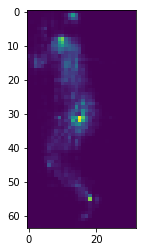

In [16]:
import matplotlib.pyplot as plt

plt.imshow(test_read[2,:].reshape(64,32))

Somehow, the first two recordings are weird in all subjects, so we will ignore them.

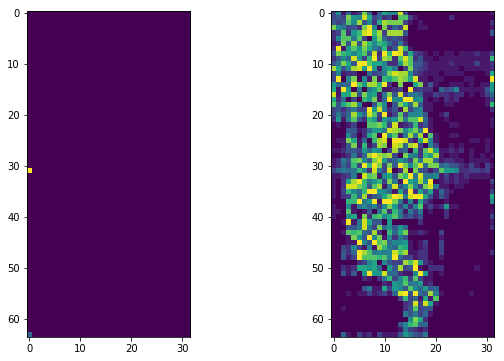

In [17]:

fig, axes = plt.subplots(figsize=(10,6), ncols=2)
for ii in range(2):
    ax = axes[ii]
    ax.imshow(test_read[ii,:].reshape(64,32))


## Build our subjects database

We want to simulate a situation where all data is stored inside each subject's device. For this, we're first going to retrieve the data and store it in a dictionary. The structure will be `{"SubjectName": (dataTensor, labelsTensor)}`

In [0]:
import torch as th

path_exp_1 = "/content/drive/My Drive//Raw_Data/experiment-i/"
positions = ["justAPlaceholder","supine", "right", "left", "right", "right", "left", "left", "supine", "supine", "supine", "supine", "supine", "right", "left", "supine", "supine", "supine"]

subjects_dict = {}

for _, dirs, _ in os.walk(path_exp_1):
  for directory in dirs:
    # each directory is a subject
    subject = directory
    data = None
    labels = None
    
    for _, _, files in os.walk(os.path.join(path_exp_1, directory)):
      for file in files:
        file_path = os.path.join(path_exp_1, directory, file)
        with open(file_path, 'r') as f:
          # Start from second recording, as the first two are corrupted
          for line in f.read().splitlines()[2:]:
            def token_position(x):
              return {
                'supine': 0,
                'left': 1,
                'right': 2,
                'left_fetus': 3,
                'right_fetus': 4
              }[x]
            
            
            raw_data = np.fromstring(line, dtype=float, sep='\t').reshape(1,64,32)
            file_data = np.round(raw_data*255/1000).astype(np.uint8) # Change the range from [0-1000] to [0-255]. This allows us to use tranforms later.
            file_label = token_position(positions[int(file[:-4])]) # Turn the file index into position list, and turn position list into reduced indices.
            file_label = np.array([file_label])
            
            if data is None:
              data = file_data
            else:
              data = np.concatenate((data, file_data), axis=0)

            if labels is None:
              labels = file_label
            else:
              labels = np.concatenate((labels, file_label), axis=0)
              
    subjects_dict[subject] = (th.from_numpy(data), th.from_numpy(labels))

## Create the workers

Now that we have our data partitioned, let's create a worker for each subject. We'll also create a secure worker, which will provide encryption mechanisms

In [0]:
%%capture
# We don't want the download process to fill our screens
!pip install syft
import syft as sy

hook = sy.TorchHook(th)

workers = [sy.VirtualWorker(id=key, hook=hook) for key in subjects_dict.keys()]

secure_worker = sy.VirtualWorker(id="secure_worker", hook=hook)

## Create the datasets and dataloaders

Now we're going to create a dataset for each subject, and their respective trainloader and testloader

In [0]:
import copy

# Let's create a copy of the data dict. This way the original dict is untouched.
subj_dict = copy.deepcopy(subjects_dict)
datasets = {}
trainloaders = {}
testloaders = {}

# Forgot that transforms aren't currently supported on federated datasets.
# transform = transforms.Compose([
#     transforms.ToPILImage(),
#     transforms.RandomAffine(15),
#     transforms.RandomResizedCrop((64,32),(0.8, 1.0)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

train_percent = 0.8

for worker in workers:
  # Create the Dataset
  datasets[worker.id] = sy.BaseDataset(*subj_dict[worker.id])
  
  train_size = int(train_percent * len(datasets[worker.id]))
  test_size = len(datasets[worker.id]) - train_size
  
  # Split the dataset for the dataloaders
  train_dataset, test_dataset = th.utils.data.random_split(datasets[worker.id], [train_size, test_size])
  
  trainloaders[worker.id] = th.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
  testloaders[worker.id] = th.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)
  
  # Send the dataset to the worker
  datasets[worker.id] = datasets[worker.id].send(worker)
  

## Define the model

This model will be copied and sent to every subject, trained locally, and then we obtain the average through the use of Additive Secret Sharing.

In [206]:
import torch
from torch import nn
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        
        #Input channels = 1, output channels = 6
        self.conv1 = torch.nn.Conv2d(1, 6, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(6, 18, kernel_size=3, stride=1, padding=1)
        
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        
        # Inputs to hidden layer linear transformation
        self.h1 = nn.Linear(18 * 16 * 8, 392)
        self.h2 = nn.Linear(392, 98)
        
        # Output layer, 5 neurons - one for each position
        self.output = nn.Linear(98, 5)
        
        # Define sigmoid activation and softmax output 
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = x.float()
        # Add a "channel dimension"
        x = x.unsqueeze(1)
        
        #Computes the activation of the first convolution
        #Size changes from (1, 64, 32) to (6, 64, 32)
        
        x = F.relu(self.conv1(x))

        
        #Size changes from (6, 64, 32) to (6, 32, 16)
        x = self.pool(x)

        
        #Size changes from (6, 32, 16) to (18, 32, 16)
        x = F.relu(self.conv2(x))

        
        #Size changes from (18, 32, 16) to (18, 16, 8)
        x = self.pool(x)
        


        
        #Reshape data to input to the input layer of the neural net
        #Size changes from (18, 16, 16) to (1, 4608)
        
        x = x.view(x.shape[0], -1)
        # Pass the input tensor through each of our operations
        x = self.h1(x)

        x = self.relu(x)
        x = self.h2(x)

        x = self.relu(x)
        x = self.output(x)

        x = self.logsoftmax(x)
        
        return x
      
net = Network()
net

Network(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (h1): Linear(in_features=2304, out_features=392, bias=True)
  (h2): Linear(in_features=392, out_features=98, bias=True)
  (output): Linear(in_features=98, out_features=5, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
)

## Train on each subject

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = "cpu" # TODO: research if cuda is supported on federated learning
net.to(device)

models = {}

for worker in workers:
  models[worker.id] = net.copy().send(worker)

In [208]:
from torch import optim

for worker in workers:
  
  model = models[worker.id]
  trainloader = trainloaders[worker.id]
  testloader = testloaders[worker.id]
  
  criterion = nn.NLLLoss()
  optimizer = optim.Adam(model.parameters(), lr = 0.00003)
  
  epochs = 3
  running_loss = 0
  train_losses, test_losses = [], []
  
  for epoch in range(epochs):
    for inputs, labels in trainloader:
      
      inputs, labels = inputs.to(device), labels.to(device)
      
      optimizer.zero_grad()
      
      logps = model.forward(inputs)
      loss = criterion(logps, labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss
      
    else:
      
      test_loss = 0
      accuracy = 0
      model.eval()
    
      with torch.no_grad():
        for inputs, labels in testloader:
          inputs, labels = inputs.to(device), labels.to(device)
          logps = model.forward(inputs)
          test_loss += criterion(logps, labels)
        
          ps = torch.exp(logps)
          top_p, top_class = ps.topk(1, dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.float())
    
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(testloader))
        
      print(f"Subject {worker.id}.. "
            f"Epoch {epoch+1}/{epochs}.. "
            f"Train loss: {running_loss.get()/len(trainloader):.3f}.. "
            f"Test loss: {test_loss.get()/len(testloader):.3f}.. "
            f"Test accuracy: {accuracy.get()/len(testloader):.3f}")
      running_loss = 0
      model.train()
      

Subject S7.. Epoch 1/3.. Train loss: 0.340.. Test loss: 0.049.. Test accuracy: 0.994
Subject S7.. Epoch 2/3.. Train loss: 0.025.. Test loss: 0.023.. Test accuracy: 0.996
Subject S7.. Epoch 3/3.. Train loss: 0.014.. Test loss: 0.018.. Test accuracy: 0.998
Subject S6.. Epoch 1/3.. Train loss: 0.640.. Test loss: 0.218.. Test accuracy: 0.996
Subject S6.. Epoch 2/3.. Train loss: 0.101.. Test loss: 0.054.. Test accuracy: 0.996
Subject S6.. Epoch 3/3.. Train loss: 0.027.. Test loss: 0.030.. Test accuracy: 0.996
Subject S11.. Epoch 1/3.. Train loss: 0.611.. Test loss: 0.197.. Test accuracy: 0.996
Subject S11.. Epoch 2/3.. Train loss: 0.098.. Test loss: 0.056.. Test accuracy: 0.996
Subject S11.. Epoch 3/3.. Train loss: 0.030.. Test loss: 0.032.. Test accuracy: 0.996
Subject S1.. Epoch 1/3.. Train loss: 0.555.. Test loss: 0.109.. Test accuracy: 1.000
Subject S1.. Epoch 2/3.. Train loss: 0.057.. Test loss: 0.021.. Test accuracy: 1.000
Subject S1.. Epoch 3/3.. Train loss: 0.014.. Test loss: 0.009.

# Combine the models into a global model and update local models

## Share the parameter's of each subject's model

We use Additive Secret Sharing to allow operations to be performed between models without sacrificing privacy. 

In [0]:
# There seems to be a bug with fix_prec() on model parameters. (https://github.com/OpenMined/PySyft/issues/2490)
# For this reason we have to do fix_prec().share() directly inside the pointers

for worker in workers:
  model = models[worker.id]
  for p in model.parameters():
    # This is equivalent to model.fix_precision().share(*workers, crypto_provider=secure_worker)
    p.data = p.data.fix_precision().share(*workers, crypto_provider=secure_worker)
    
  models[worker.id] = model
    

In [210]:
# Sanity Check

param = list(models['S1'].parameters())[0]

# This should be (Wrapper)>FixedPrecisionTensor>[AdditiveSharingTensor]
param.location._objects[param.id_at_location]

(Wrapper)>FixedPrecisionTensor>[AdditiveSharingTensor]
	-> [PointerTensor | me:61981393664 -> S7:40140708010]
	-> [PointerTensor | me:23573350900 -> S6:99886566095]
	-> [PointerTensor | me:580319310 -> S11:7926000529]
	-> [PointerTensor | me:4833954232 -> S1:87287490813]
	-> [PointerTensor | me:19469347327 -> S10:33533640553]
	-> [PointerTensor | me:24218876085 -> S8:87447698120]
	-> [PointerTensor | me:56705149037 -> S3:86836441115]
	-> [PointerTensor | me:36861282517 -> S4:83430705187]
	-> [PointerTensor | me:98382962021 -> S5:20672341301]
	-> [PointerTensor | me:79830450987 -> S2:4260966236]
	-> [PointerTensor | me:39844086730 -> S13:67192189404]
	-> [PointerTensor | me:42023766767 -> S9:10201691164]
	-> [PointerTensor | me:86187416335 -> S12:65497849715]
	*crypto provider: secure_worker*

In [211]:
models['S1']

Network(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 18, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (h1): Linear(in_features=2304, out_features=392, bias=True)
  (h2): Linear(in_features=392, out_features=98, bias=True)
  (output): Linear(in_features=98, out_features=5, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
)

## Move the encrypted models to our secure worker

Note that the data is still encrypted and shared among all devices. This is only so that all the aggregation is executed by the secure_worker.

In [0]:
for m_id in models:
  models[m_id].move(secure_worker)

## Combine the parameters

In [216]:
# Iterate over every layer of the global model
for i, layer in enumerate(list(net.children())):
  
  # Check if current layer has weights and biases
  if len(list(layer.parameters())) != 2:
    continue
  
  # Set variables to store the aggregation
  weight = None
  bias = None
  
  # Iterate over every model
  for m_id in models:
    model = models[m_id]
    m_layer = list(model.children())[i]
    
    # Aggregate current layer's weight
    if weight is None:
      weight = m_layer.weight
    else:
      weight += m_layer.weight
    
    # Aggregate current layer's bias
    if bias is None:
      bias = m_layer.bias
    else:
      bias += m_layer.bias
      
      
  # Assign the parameters to our global model
  with th.no_grad():
    
    # Would be nice to do the mean inside secure_worker,
    # but float_prec() is not currently supported on pointer tensors 
    # https://github.com/OpenMined/PySyft/pull/2443
    
    layer.weight.set_(weight.get().get().float_prec()/len(models))
    layer.bias.set_(bias.get().get().float_prec()/len(models))

TensorsNotCollocatedException: ignored

## Update all local models with out global model

Our global model represents a more generalized model. Now we can replace each subject's models with this one. This way, we're obtaining the benefit of using multiple subject's data while retaining privacy.

In [0]:
for worker in workers:
  models[worker.id] = net.copy().send(worker)

## Check the results

This model should have a good accuracy on every subject. Let's test this hypothesis by running the model locally on our remote testloaders

In [215]:
for worker in workers:
  
  model = models[worker.id]
  testloader = testloaders[worker.id]
  
  criterion = nn.NLLLoss()
  
  test_loss = 0
  accuracy = 0
  model.eval()
    
  with torch.no_grad():
    for inputs, labels in testloader:
      inputs, labels = inputs.to(device), labels.to(device)
      logps = model.forward(inputs)
      test_loss += criterion(logps, labels)
        
      ps = torch.exp(logps)
      top_p, top_class = ps.topk(1, dim=1)
      equals = top_class == labels.view(*top_class.shape)
      accuracy += torch.mean(equals.float())
      
  print(f"Subject {worker.id}.. "
    f"Test loss: {test_loss.get()/len(testloader):.3f}.. "
    f"Test accuracy: {accuracy.get()/len(testloader):.3f}")

Subject S7.. Test loss: 0.201.. Test accuracy: 0.929
Subject S6.. Test loss: 0.256.. Test accuracy: 0.941
Subject S11.. Test loss: 0.390.. Test accuracy: 0.761
Subject S1.. Test loss: 0.292.. Test accuracy: 0.891
Subject S10.. Test loss: 0.311.. Test accuracy: 0.826
Subject S8.. Test loss: 0.461.. Test accuracy: 0.777
Subject S3.. Test loss: 0.265.. Test accuracy: 0.837
Subject S4.. Test loss: 0.274.. Test accuracy: 0.874
Subject S5.. Test loss: 0.255.. Test accuracy: 0.933
Subject S2.. Test loss: 0.473.. Test accuracy: 0.806
Subject S13.. Test loss: 0.342.. Test accuracy: 0.849
Subject S9.. Test loss: 0.166.. Test accuracy: 1.000
Subject S12.. Test loss: 0.158.. Test accuracy: 0.998


In [201]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 64, 32).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(5), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(5))
  
    ax2.set_yticklabels(['supine', 'left', 'right', 'left_fetus', 'right_fetus'], size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

for inputs, labels, _ in trainloader:
  inputs, labels = inputs.to(device), labels.to(device)
  view_classify(inputs[0].unsqueeze(0).cpu(), torch.exp(model.forward(inputs[0].unsqueeze(0))).cpu())


ValueError: ignored

In [0]:
from torchvision import transforms

trans = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomAffine(15),
    transforms.RandomResizedCrop((64,32),(0.8, 1.0)),
    transforms.ToTensor()
])

myimage = inputs[2].cpu().float()

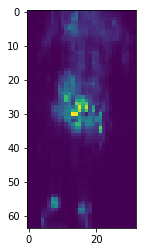

In [0]:
plt.imshow(trans(myimage).view(64,32))

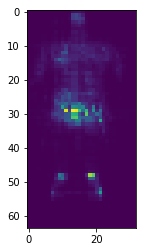

In [0]:
plt.imshow(myimage)

In [0]:
trans(myimage).view(64,32)

tensor([[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.9961, 0.9882, 1.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9882,  ..., 0.0000, 0.0000, 0.0000]])

In [0]:
myimage

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        [2., 4., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 4.,  ..., 0., 0., 0.]])